In [5]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import os
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import joblib

In [6]:
#os.chdir(os.pardir)

In [7]:
os.getcwd()

'c:\\Users\\dwarf\\Dataproject'

In [8]:
#os.chdir("C:\Dataproject")

In [9]:
k_mers = ["2","2","4","4","6","6"]
checks = [True,False,True,False,True,False]
colors = ["b","g","r","c","m","y"]
model_probs = []

In [10]:
def pca(train_data, test_data): 
        dim_reduction = PCA()
        train_fit = dim_reduction.fit_transform(train_data)
        test_fit = dim_reduction.transform(test_data)
        return [train_fit, test_fit]

In [11]:
def pca2(X, comp = None): 
        dim_reduction = PCA(n_components=comp)
        X = dim_reduction.fit_transform(X)
        return [X]

In [12]:
Meth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[0] + "mers_meth_with_background.tsv", sep="\t")
Meth = Meth.drop(306)
cancer_list = []
for j in range(0,306):
    if Meth.loc[j,"cancer"]!="Healthy":
        cancer_list.append(0)
    else:
        cancer_list.append(1)

for j in range(307,len(Meth)+1):
    if Meth.loc[j,"cancer"]!="Healthy":
        cancer_list.append(0)
    else:
        cancer_list.append(1)
Unmeth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[0] + "mers_unmeth_with_background.tsv", sep="\t")
Unmeth = Unmeth.drop(306)

for j in range(0,306):
    if Meth.loc[j,"cancer"]!="Healthy":
        cancer_list.append(0)
    else:
        cancer_list.append(1)

for j in range(307,len(Unmeth)+1):
    if Meth.loc[j,"cancer"]!="Healthy":
        cancer_list.append(0)
    else:
        cancer_list.append(1)


In [13]:
print(len(cancer_list))

948


In [14]:
results = []
model_probs = []
for i in range(len(k_mers)):

    #os.chdir(os.pardir)
    Meth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[i] + "mers_meth_with_background.tsv", sep="\t")
    Unmeth = pd.read_csv("processed_data\combined_data\with_background\combined_" + k_mers[i] + "mers_unmeth_with_background.tsv", sep="\t")
    Meth = Meth.drop(306)
    Unmeth = Unmeth.drop(306)
    Combined = [Meth,Unmeth]
    Healthy_Meth = Meth.loc[Meth["cancer"]=="Healthy"]
    Healthy_Unmeth = Unmeth.loc[Unmeth["cancer"]=="Healthy"]
    Data0 = Healthy_Meth
    Data1 = Healthy_Unmeth
    Combined = [Data0,Data1]
    X = pd.concat(Combined)
    X = X.iloc [:, :-1]
    dim_reduction = PCA()
    y = [0] * Data0.shape[0] + [1] * Data1.shape[0]
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    X_train = dim_reduction.fit_transform(X_train)
    X_test = dim_reduction.transform(X_test)

    # Create a pipeline with standardization and logistic regression with L1 regularization
    pipe = make_pipeline(LogisticRegression(penalty='l1', solver='liblinear',max_iter=1000))
    # Define hyperparameters grid for GridSearchCV
    param_grid = {
        'logisticregression__C': np.logspace(-3, 3, 1000)  # Values for regularization parameter C
    }

    # Create GridSearchCV object
    grid_search = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)
    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)



    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Evaluate the best model
    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)
    num_selected_variables = np.sum(best_model.named_steps['logisticregression'].coef_ != 0)

    results.append([test_accuracy, grid_search.best_params_["logisticregression__C"], num_selected_variables,[k_mers[i],checks[i]]])


    plt.scatter(grid_search.cv_results_['param_logisticregression__C'], grid_search.cv_results_['mean_test_score'], color = colors[i])
    plt.plot(grid_search.cv_results_['param_logisticregression__C'], grid_search.cv_results_['mean_test_score'], color = colors [i])
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.savefig("Cross_Val " + k_mers[i] + "-mer, PCA = " + str(checks[i]))
    plt.close()
    dump(best_model,"Straight_Cross_Val_" + k_mers[i] + "_mer__PCA_=_" + str(checks[i]) + ".joblib")
    Data0 = Meth
    Data1 = Unmeth
    Combined = [Data0,Data1]
    X2 = pd.concat(Combined)
    X2 = X2.iloc [:, :-1]
    X2 = dim_reduction.transform(X2)
    probs = grid_search.predict_proba(X2)
    y = [0] * Data0.shape[0] + [1] * Data1.shape[0]
    Meth_h_probs = []
    Unmeth_h_probs = []
    Meth_c_probs = []
    Unmeth_c_probs = []
    for j in range(len(probs)):
        if y[j] == 0 and cancer_list[j] == 1:
            Meth_h_probs.append(probs[j][0])
        elif y[j] == 0 and cancer_list[j] == 0:
            Meth_c_probs.append(probs[j][0])
        elif y[j] == 1 and cancer_list[j] == 1:
            Unmeth_h_probs.append(probs[j][1])
        elif y[j] == 1 and cancer_list[j] == 0:
            Unmeth_c_probs.append(probs[j][1])
    model_probs.append([[Meth_h_probs,Unmeth_h_probs],[Meth_c_probs,Unmeth_c_probs]])


    print("Best model:", best_model)
    print("Best parameter (C):", grid_search.best_params_)
    print("Train accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)



Best model: Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=10.865157746525373, max_iter=1000,
                                    penalty='l1', solver='liblinear'))])
Best parameter (C): {'logisticregression__C': 10.865157746525373}
Train accuracy: 1.0
Test accuracy: 0.9958847736625515
Best model: Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=148.3102514336103, max_iter=1000,
                                    penalty='l1', solver='liblinear'))])
Best parameter (C): {'logisticregression__C': 148.3102514336103}
Train accuracy: 1.0
Test accuracy: 1.0
Best model: Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=430.16357581067905, max_iter=1000,
                                    penalty='l1', solver='liblinear'))])
Best parameter (C): {'logisticregression__C': 430.16357581067905}
Train accuracy: 1.0
Test accuracy: 0.9958847736625515
Best model: Pipeline(steps=[('logisticregression',
               

In [15]:
#grid_search.predict_proba(X)

In [16]:
print(len(probs))

948


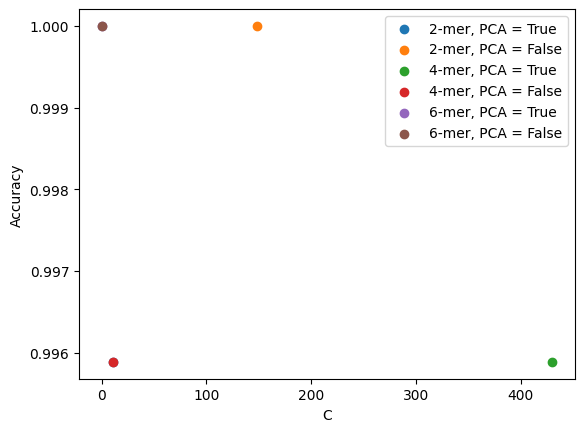

In [17]:
for i in range(len(results)):
    plt.scatter(results[i][1],results[i][0],label=results[i][3][0] + "-mer, PCA = " + str(results[i][3][1]))
plt.legend() 
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.savefig("Cross_Val")

In [18]:
C = []
N_var = []
Acc = []
k_mer = []
princ = []
for i in range(len(results)):
    C.append(results[i][1])
    Acc.append(results[i][0])
    N_var.append(results[i][2])
    k_mer.append(results[i][3][0])
    princ.append(results[i][3][1])
Extra = pd.DataFrame({'k-mer':k_mer, 'PCA': princ, 'C': C, 'Accuracy': Acc, 'Number of variables': N_var})

In [19]:
Extra

,k-mer,PCA,C,Accuracy,Number of variables
0,2,True,10.865158,0.995885,9
1,2,False,148.310251,1.000000,13
2,4,True,430.163576,0.995885,18
3,4,False,10.715934,0.995885,9
4,6,True,0.002053,1.000000,1
5,6,False,0.002081,1.000000,1


In [20]:
len(model_probs)
model_probs[0][0][0]

[0.9951842956972539,
 0.9967594166423979,
 0.9883926012612846,
 0.9972747893526531,
 0.9826719045313869,
 0.9306576668285937,
 0.982535305509846,
 0.9929498685523215,
 0.8750789880003248,
 0.9845790565800188,
 0.9854822008843237,
 0.9942252799771946,
 0.9946228767618561,
 0.9853035611724688,
 0.9656695508399338,
 0.9645550392320056,
 0.9493776820152345,
 0.9650207942019885,
 0.9784839052331924,
 0.9900626768673443,
 0.9997443936352455,
 0.9803093594056539,
 0.998918928351142,
 0.9959288646466481,
 0.9885198877375205,
 0.9949096780614857,
 0.9740373842801922,
 0.9831094372331518,
 0.9886741741988159,
 0.8090102206913354,
 0.9638673987385005,
 0.9988127775838878,
 0.9928834931420488,
 0.9882485628819082,
 0.9970457564395072,
 0.99165240102298,
 0.9446314219061918,
 0.9952204007185745,
 0.9605870933083883,
 0.9868689166526617,
 0.9254444359097842,
 0.9345673497690025,
 0.9443730548426216,
 0.9838300585402531,
 0.9455432214199081,
 0.9945262659287357,
 0.9795355399284617,
 0.99076065702516

In [21]:
methylation = ["Methylated","Unmethylated"]
cancers = ["Noncancer","Cancer"]

for i in range(len(model_probs)):
    for j in range(len(model_probs[i])):
        for l in range(len(model_probs[i][j])):
            print(k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l] + " Avg prediction = " + str(np.mean(model_probs[i][j][l])))
            #print(k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l])
            #sns_plot=sns.displot(x=model_probs[i][j][l])
            #plt.hist(x=model_probs[i][j][l])
            #plt.title(k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l])
            #plt.savefig(fname=k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l])
            #sns_plot.set(title=k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l])
            #sns_plot.figure.savefig(k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", " + cancers[j] + " " + methylation[l]+".png")
            

2-mer, PCA = True, Noncancer Methylated Avg prediction = 0.954727935646247
2-mer, PCA = True, Noncancer Unmethylated Avg prediction = 0.9504446196663512
2-mer, PCA = True, Cancer Methylated Avg prediction = 0.8221619515735672
2-mer, PCA = True, Cancer Unmethylated Avg prediction = 0.89802949984776
2-mer, PCA = False, Noncancer Methylated Avg prediction = 0.9949191138517416
2-mer, PCA = False, Noncancer Unmethylated Avg prediction = 0.9958890922130108
2-mer, PCA = False, Cancer Methylated Avg prediction = 0.8842698069491687
2-mer, PCA = False, Cancer Unmethylated Avg prediction = 0.9674732638723581
4-mer, PCA = True, Noncancer Methylated Avg prediction = 0.9969464943028784
4-mer, PCA = True, Noncancer Unmethylated Avg prediction = 0.9989129049530555
4-mer, PCA = True, Cancer Methylated Avg prediction = 0.99308681189074
4-mer, PCA = True, Cancer Unmethylated Avg prediction = 0.9459167570614883
4-mer, PCA = False, Noncancer Methylated Avg prediction = 0.9949806542936958
4-mer, PCA = False

In [22]:
for i in range(len(model_probs)):
    for j in range(len(model_probs[i])):
        for l in range(len(model_probs[i][j])):
            cancer_probs = model_probs[i][j][l][0]  # Assuming cancer is the first index
            healthy_probs = model_probs[i][j][l][1]  # Assuming healthy is the second index
            
          

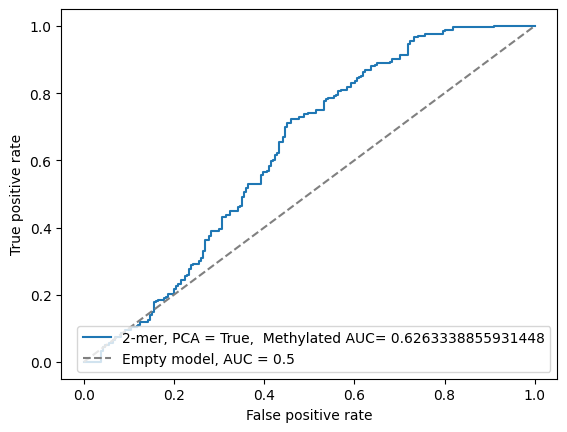

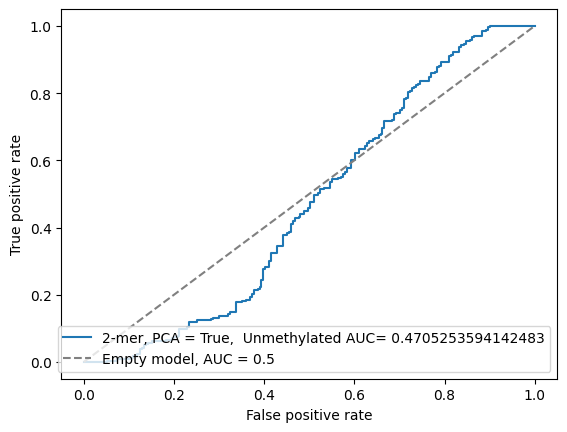

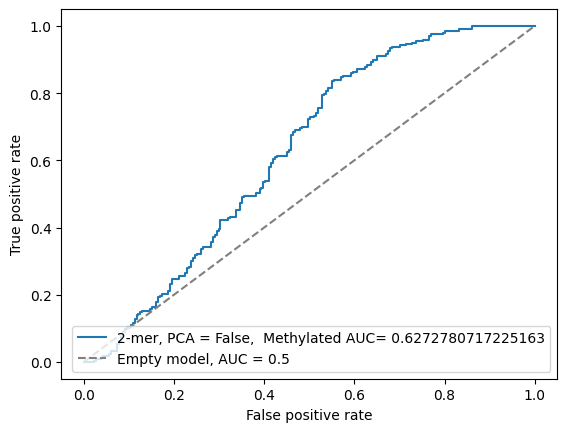

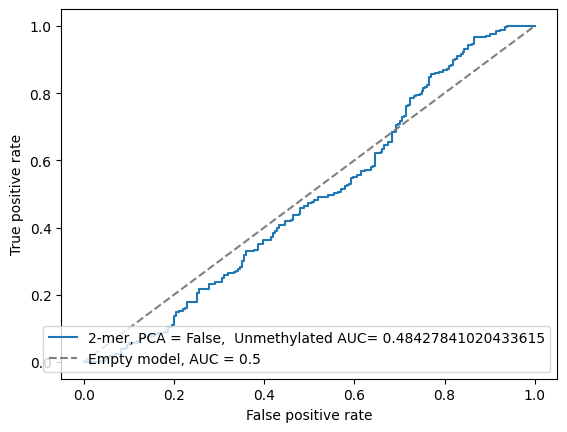

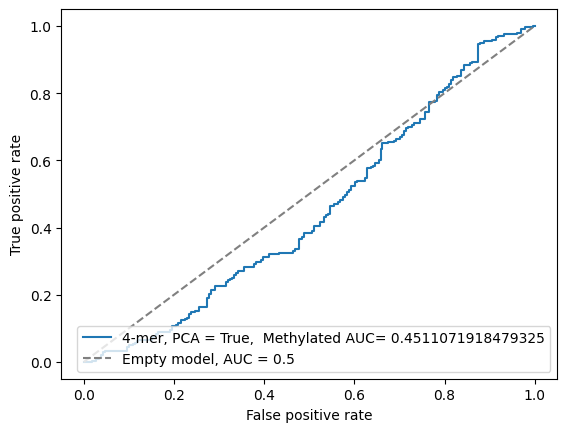

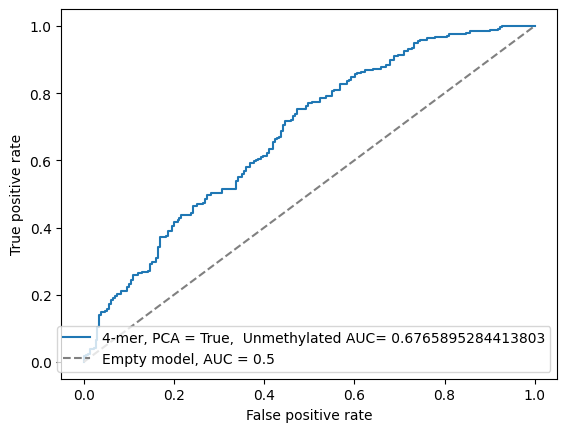

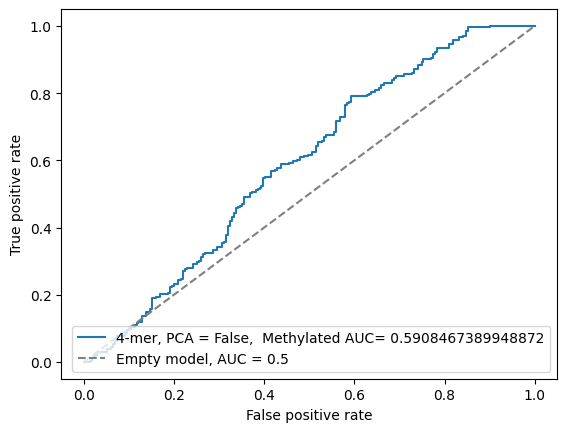

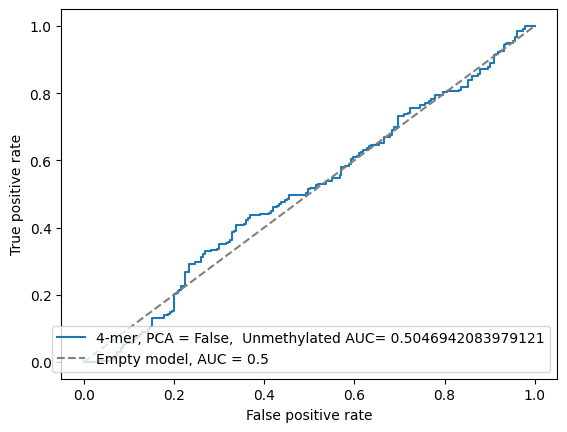

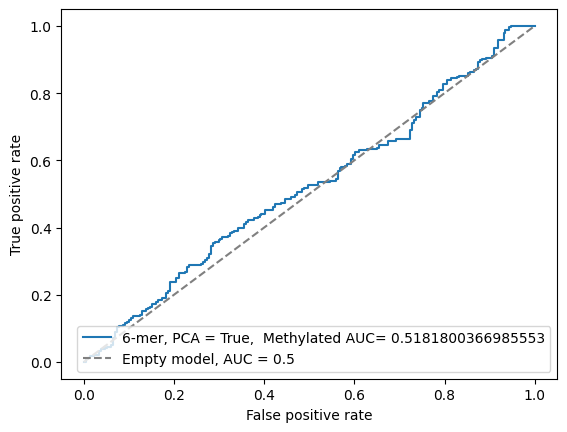

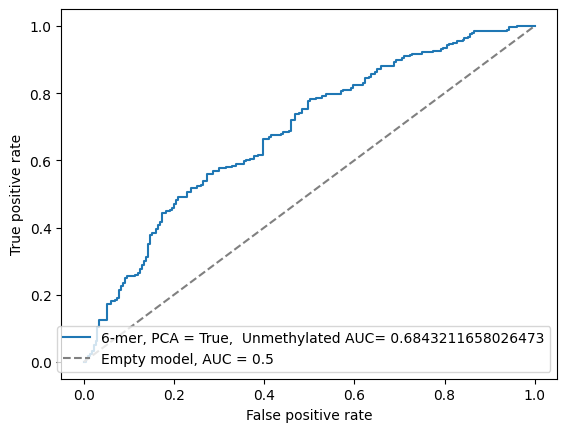

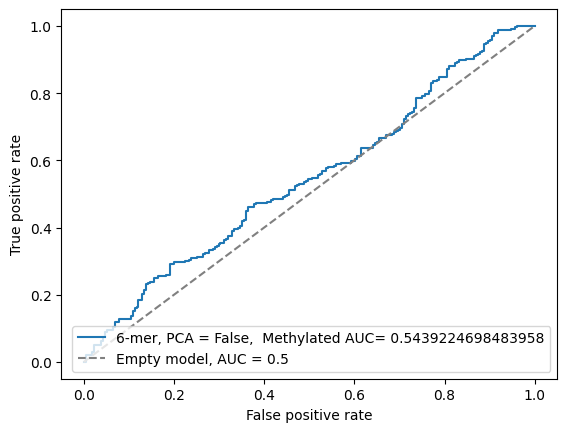

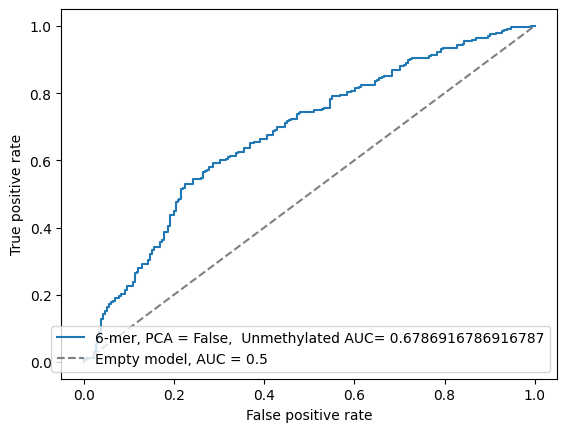

In [23]:
for i in range(len(model_probs)):
    #for j in range(len(model_probs[i])):
        for l in range(len(model_probs[i][0])):
            #fig, ax0 = plt.subplots(nrows=1, ncols=1)
            #x = [model_probs[i][0][l],model_probs[i][1][l]]
            #ax0.hist(x, n_bins, density=True, histtype='bar', color=new_colors, label=cancers)
            #ax0.legend(prop={'size': 10})   
            #ax0.set_title(k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", "  + " " + methylation[l])
            y = [0] * len(model_probs[i][1][l])
            y += [1] * len(model_probs[i][0][l])
            y_scores = model_probs[i][1][l]
            y_scores += model_probs[i][0][l]
            fpr, tpr, _ = metrics.roc_curve(y, y_scores)
            #display = DetCurveDisplay(fpr=fpr, fnr=fnr, estimator_name=k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", "  + " " + methylation[l])
            AUC = metrics.roc_auc_score(y, y_scores)
            #plt.close()
            plt.plot(fpr,tpr, label =  k_mers[i]+"-mer, PCA = " + str(checks[i]) + ", "  + " " + methylation[l] + " AUC= " + str(AUC))
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label= "Empty model, " +  'AUC = 0.5')
            plt.xlabel("False positive rate")
            plt.ylabel("True positive rate")
            plt.legend(loc = "lower right")
            plt.savefig(fname =k_mers[i]+"-mer, PCA = " + str(checks[i]) +  " " + methylation[l])
            plt.show()
            plt.close()